In [1]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

from py_wake.flow_map import Points

from py_wake.wind_turbines._wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake import HorizontalGrid
from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.utils.plotting import setup_plot

In [2]:
D = 100 # Rotor diameter
s = 7 # Turbine spacing

u = np.arange(0, 25.5, .5)
po = [0, 0, 0, 0, 5, 15, 37, 73, 122, 183, 259, 357, 477, 622, 791, 988, 1212, 1469, 1755, 2009, 2176, 2298, 2388, 2447, 2485, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 0]
ct = [0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0]

wt1 = WindTurbine(name="Ørsted1", diameter=100, hub_height=100, powerCtFunction=PowerCtTabular(u, po, 'kw', ct))

u2 = np.arange(0, 27)
pow2 = [0, 0, 0, 0, 54, 144, 289, 474, 730, 1050, 1417, 1780, 2041, 2199, 2260, 2292, 2299, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 0]
ct2  = [0, 0, 0, 0, 0.94, 0.82, 0.76, 0.68, 0.86, 0.83, 0.77, 0.68, 0.66, 0.52, 0.47, 0.41, 0.38, 0.34, 0.27, 0.26, 0.23, 0.22, 0.22, 0.2, 0.16, 0.17, 0]
wt2 = WindTurbine(name="Ørsted2", diameter=80, hub_height=70, powerCtFunction=PowerCtTabular(u2, pow2, 'kw', ct2))
wts = WindTurbines.from_WindTurbine_lst([wt1,wt2])

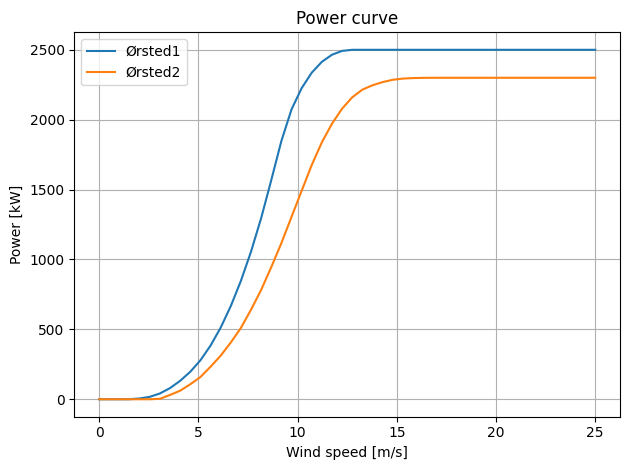

In [3]:
u = np.linspace(0,25)

for t in [0,1]:
    plt.plot(u,wts.power(u, type=t)/1000, label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]', title='Power curve')

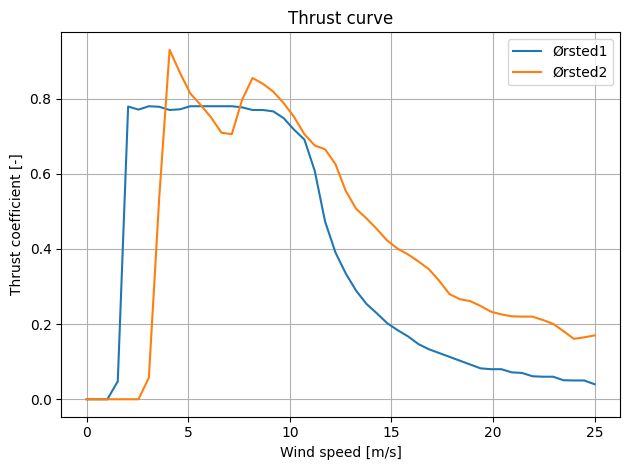

In [4]:
for t in [0,1]:
    plt.plot(u,wts.ct(u, type=t), label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Thrust coefficient [-]', title='Thrust curve')

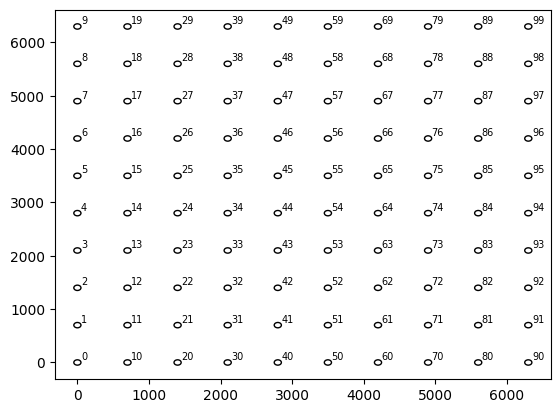

In [5]:
u0 = [6, 7, 8, 9, 10, 11, 12, 13, 14] # [m/s]
wd = 270 # [deg]
ti0 = [0.09, 0.1, 0.11, 0.12, 0.14, 0.15, 0.16, 0.17, 0.18] # [-]

y, x = [v.flatten() for v in np.meshgrid(np.arange(10) * D * s, np.arange(10) * D * s)]
wt1.plot(x, y)

In [6]:
site = UniformSite(shear=PowerShear(h_ref=90, alpha=.1))
wfm = PropagateDownwind(site, wt1, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True), superpositionModel=LinearSum())
sim = wfm(x, y, ws=u0, wd=wd, TI=ti0)

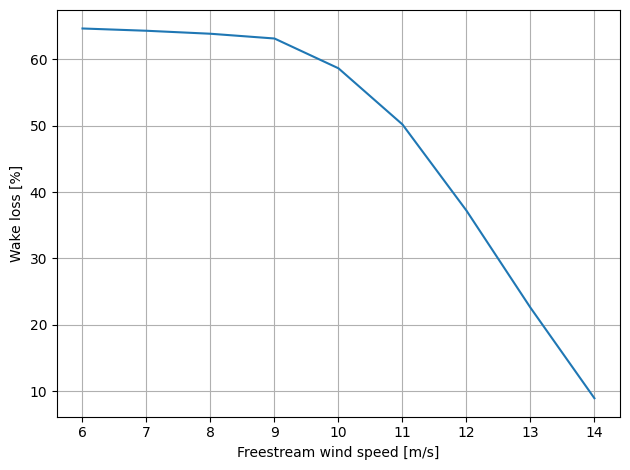

In [7]:
((1-(sim.Power.mean('wt') / sim.Power.max('wt')))*100).plot()
setup_plot(ylabel='Wake loss [%]', xlabel='Freestream wind speed [m/s]')

In [11]:
x_end = max(x) + 1*D*s # 1 spacing after downstream edge

y_end = np.linspace(min(y)-D/2, max(y)+D/2, max(y)+D, endpoint=False)

zh = wt1.hub_height()

ws_end = np.squeeze(
    sim.flow_map(Points(x=x_end * np.ones_like(y_end), 
                        y=y_end, 
                        h=zh * np.ones_like(y_end)))).WS_eff.values

ws_avg_end = np.mean(ws_end)

print(f"Downstream edge at: {x_end} m")
print(f"Average wind speed: {ws_avg_end:.2f} m/s")

Downstream edge at: 7000 m
Average wind speed: 9.02 m/s


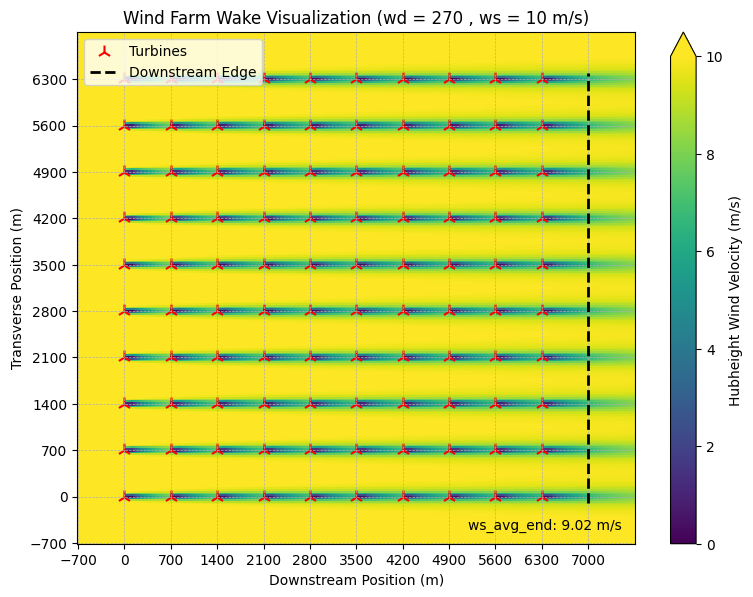

In [12]:
# --- Wake Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# Compute the flow map and grid
flow_map_grid = HorizontalGrid(x=np.linspace(min(x)-1*100*7, max(x)+2*D*s, 300), y=np.linspace(min(y)-1*D*s, max(y)+1*D*s, 300))
flow_map = sim.flow_map(grid=flow_map_grid)
wake_map = flow_map.sel(wd=wd, ws=10, method="nearest")
vmin, vmax = 0, 10

wake_map.WS_eff.plot(ax=ax, cmap="viridis", vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'Hubheight Wind Velocity (m/s)'})

# Plot turbine positions
ax.scatter(x, y, color="red", marker="2", s=100, label="Turbines")
ax.vlines(x=x_end, ymin=min(y)-1*D, ymax=max(y)+1*D, color='black', linestyle='--', linewidth=2, label="Downstream Edge")
ax.set_title("Wind Farm Wake Visualization (wd = " + str(wd) + " , ws = " + str(10) + " m/s)")
ax.set_xlabel("Downstream Position (m)")
ax.set_ylabel("Transverse Position (m)")
ax.set_aspect('equal')
ax.legend(loc='upper left')
plt.text(0.975, 0.05, f'ws_avg_end: {ws_avg_end:.2f} m/s', ha='right', va='top', transform=ax.transAxes)

# Add grid with ticklines every 700 in both x and y
ax.set_xticks(np.arange(min(x)-1*D*s, max(x)+2*D*s, 700))
ax.set_yticks(np.arange(min(y)-1*D*s, max(y)+1*D*s, 700))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

In [13]:
''' Old averaging

x_target = 7*100*10 # Replace with your desired x-coordinate
velocity_at_x = wake_map.WS_eff.sel(x=x_target, method="nearest").mean(dim="y").item()
print(f"Wind velocity at x = {x_target} m: {velocity_at_x:.2f} m/s")
'''

' Old averaging\n\nx_target = 7*100*10 # Replace with your desired x-coordinate\nvelocity_at_x = wake_map.WS_eff.sel(x=x_target, method="nearest").mean(dim="y").item()\nprint(f"Wind velocity at x = {x_target} m: {velocity_at_x:.2f} m/s")\n'